In [1]:
!kaggle datasets download -d mateuszbuda/lgg-mri-segmentation


Dataset URL: https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation
License(s): CC-BY-NC-SA-4.0
lgg-mri-segmentation.zip: Skipping, found more recently modified local copy (use --force to force download)


In [2]:
!pip install kaggle

In [3]:
import zipfile

with zipfile.ZipFile('lgg-mri-segmentation.zip', 'r') as zip_ref:
    # Lister tous les fichiers dans le dossier kaggle_3m
    files_to_extract = [f for f in zip_ref.namelist() if f.startswith("kaggle_3m/")]
    
    # Extraire seulement les fichiers du dossier kaggle_3m
    zip_ref.extractall('/kaggle/working/lgg_mri_segmentation', members=files_to_extract)


In [ ]:
#Import Libraries
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from skimage.io import imread
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage import io
plt.style.use("ggplot")
%matplotlib inline
import cv2
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread
from skimage.transform import resize
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from PIL import Image


In [ ]:

# Fonction pour vérifier la présence de la tumeur dans le masque
def check_tumor_in_mask(mask_path):
    try:
        img = Image.open(mask_path)
        img = np.array(img)

        if np.max(img) > 0:
            return 1 
        else:
            return 0 
    except Exception as e:
        print(f"Erreur de lecture du masque {mask_path}: {e}")
        return -1 

DataPath = "/kaggle/working/lgg_mri_segmentation/kaggle_3m/"

dirs = []
images = []
masks = []
diagnoses = []

for dirname, _, filenames in os.walk(DataPath):
    for filename in filenames:
        if 'mask' in filename:  
           
            mask_path = os.path.join(dirname, filename)
            dirs.append(dirname.replace(DataPath, ''))
            masks.append(filename)
            
            images.append(filename.replace('_mask', '')) 
            diagnosis = check_tumor_in_mask(mask_path)
            diagnoses.append(diagnosis)

patient_mri_df = pd.DataFrame({'patient_id': dirs, 'images': images, 'masks': masks, 'diagnosis': diagnoses})

patient_mri_df.head()


,patient_id,images,masks,diagnosis
0,TCGA_HT_7856_19950831,TCGA_HT_7856_19950831_4.tif,TCGA_HT_7856_19950831_4_mask.tif,0
1,TCGA_HT_7856_19950831,TCGA_HT_7856_19950831_26.tif,TCGA_HT_7856_19950831_26_mask.tif,1
2,TCGA_HT_7856_19950831,TCGA_HT_7856_19950831_13.tif,TCGA_HT_7856_19950831_13_mask.tif,1
3,TCGA_HT_7856_19950831,TCGA_HT_7856_19950831_1.tif,TCGA_HT_7856_19950831_1_mask.tif,0
4,TCGA_HT_7856_19950831,TCGA_HT_7856_19950831_18.tif,TCGA_HT_7856_19950831_18_mask.tif,1


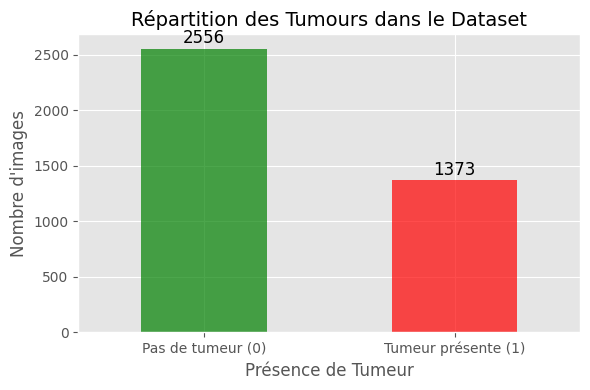

In [ ]:
diagnosis_counts = patient_mri_df['diagnosis'].value_counts()

plt.figure(figsize=(6, 4))
diagnosis_counts.plot(kind='bar', color=['green', 'red'], alpha=0.7)
plt.title('Répartition des Tumours dans le Dataset', fontsize=14)
plt.xlabel('Présence de Tumeur', fontsize=12)
plt.ylabel('Nombre d\'images', fontsize=12)
plt.xticks(ticks=[0, 1], labels=['Pas de tumeur (0)', 'Tumeur présente (1)'], rotation=0)
for i, count in enumerate(diagnosis_counts):
    plt.text(i, count + 10, str(count), ha='center', va='bottom', fontsize=12)
plt.tight_layout()
plt.show()


In [7]:
pip install imageio


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Note: you may need to restart the kernel to use updated packages.


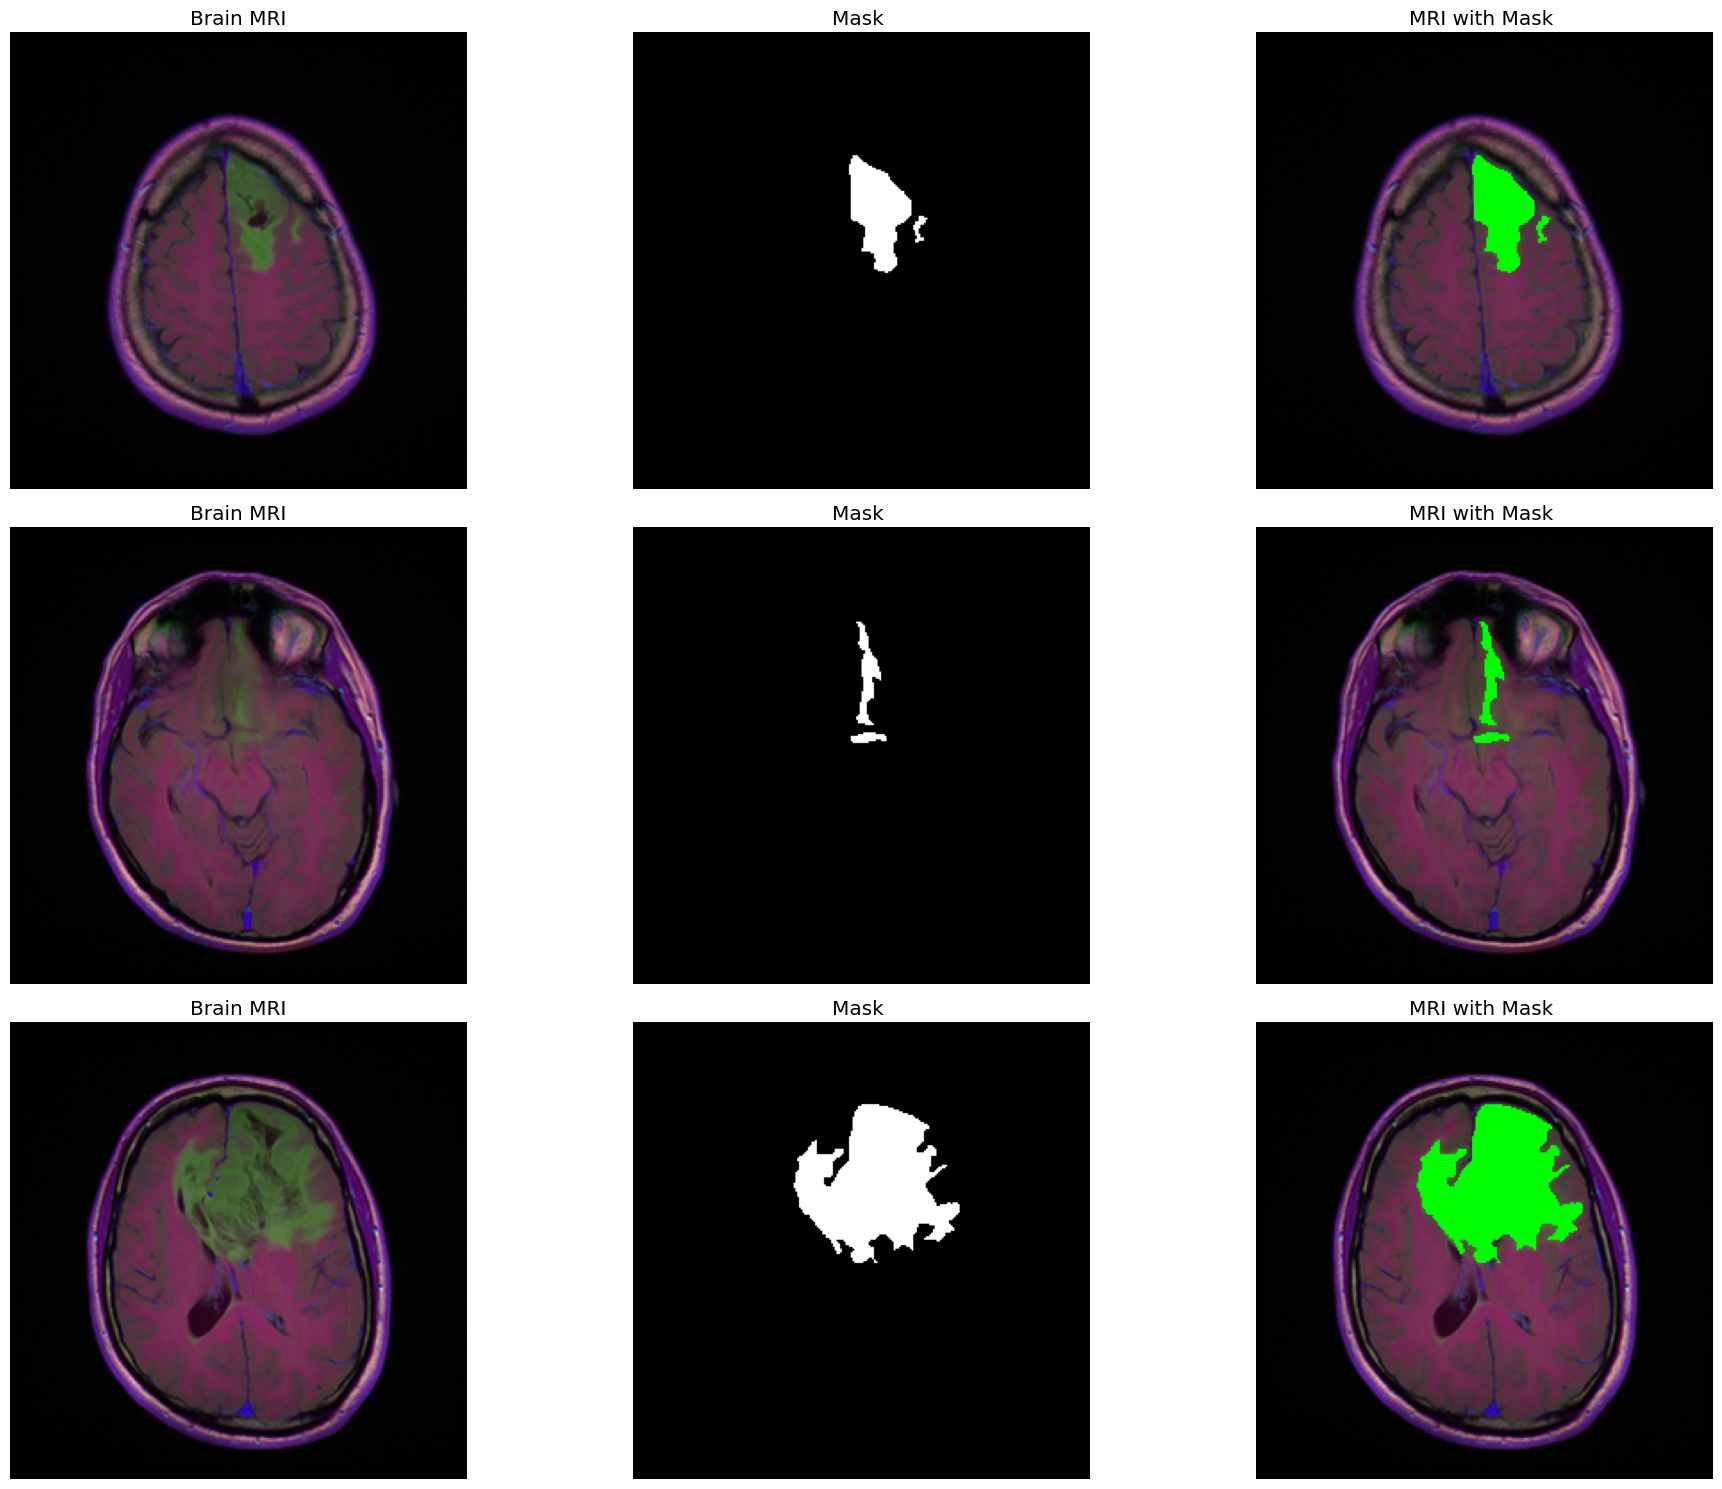

In [ ]:

count = 0
fig, axs = plt.subplots(3, 3, figsize=(20, 15))
axs = axs.flatten()

for i, row in patient_mri_df.iterrows():
    if row['diagnosis'] == 1:
        img_path = os.path.join(DataPath, row['patient_id'], row['images'])
        mask_path = os.path.join(DataPath, row['patient_id'], row['masks'])

        img = imread(img_path)  
        mask = imread(mask_path) 

        axs[count].imshow(img)
        axs[count].set_title("Brain MRI")
        axs[count].axis('off')

        axs[count + 1].imshow(mask, cmap='gray')
        axs[count + 1].set_title(f"Mask ")
        axs[count + 1].axis('off')

        img_with_mask = img.copy()
        img_with_mask[mask == 255] = (0, 255, 0)
        axs[count + 2].imshow(img_with_mask)
        axs[count + 2].set_title(f"MRI with Mask ")
        axs[count + 2].axis('off')

        count += 3

    if count >= 9:
        break

fig.tight_layout()
plt.show()


In [ ]:

# Diviser le DataFrame en ensembles d'entraînement et de test (25% test, 75% train)
train, test = train_test_split(patient_mri_df, test_size=0.25, random_state=25)

# Diviser l'ensemble d'entraînement en sous-ensembles d'entraînement et de validation (10% de l'entraînement pour la validation)
train, val = train_test_split(train, test_size=0.1, random_state=25)

print(f"Taille de l'ensemble d'entraînement: {len(train)}")
print(f"Taille de l'ensemble de validation: {len(val)}")
print(f"Taille de l'ensemble de test: {len(test)}")

print(train.head())

Taille de l'ensemble d'entraînement: 2651
Taille de l'ensemble de validation: 295
Taille de l'ensemble de test: 983
                 patient_id                        images  \
2754  TCGA_FG_A60K_20040224  TCGA_FG_A60K_20040224_64.tif   
1556  TCGA_FG_6690_20020226  TCGA_FG_6690_20020226_33.tif   
1620  TCGA_HT_8113_19930809  TCGA_HT_8113_19930809_16.tif   
1067  TCGA_DU_7014_19860618  TCGA_DU_7014_19860618_53.tif   
3616  TCGA_HT_7860_19960513   TCGA_HT_7860_19960513_9.tif   

                                  masks  diagnosis  
2754  TCGA_FG_A60K_20040224_64_mask.tif          0  
1556  TCGA_FG_6690_20020226_33_mask.tif          1  
1620  TCGA_HT_8113_19930809_16_mask.tif          1  
1067  TCGA_DU_7014_19860618_53_mask.tif          0  
3616   TCGA_HT_7860_19960513_9_mask.tif          0  


In [10]:
data_augmentation = dict(rotation_range=0.2,
                        width_shift_range=0.05,
                        height_shift_range=0.05,
                        shear_range=0.05,
                        zoom_range=0.05,
                        horizontal_flip=True,
                        fill_mode='nearest')

In [ ]:
def adjust_data(img, mask):
    img = img / 255  
    mask = mask / 255  
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    
    return img, mask

def data_generator(data_frame, batch_size, aug_dict,
                   image_color_mode="rgb", mask_color_mode="grayscale",
                   image_save_prefix="image", mask_save_prefix="mask",
                   save_to_dir=None, target_size=(256, 256), seed=1):

    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)

    
    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col="images", 
        class_mode=None,  
        color_mode=image_color_mode,
        target_size=target_size,  
        batch_size=batch_size,
        save_to_dir=save_to_dir,  
        save_prefix=image_save_prefix,
        seed=seed
    )

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col="masks",  
        class_mode=None, 
        color_mode=mask_color_mode,
        target_size=target_size,  
        batch_size=batch_size,
        save_to_dir=save_to_dir, 
        save_prefix=mask_save_prefix,
        seed=seed
    )

    train_generator = zip(image_generator, mask_generator)

    for (img, mask) in train_generator:
        img, mask = adjust_data(img, mask)  
        yield img, mask


In [ ]:
train['images'] = train.apply(lambda row: os.path.join(DataPath, row['patient_id'], row['images']), axis=1)
train['masks'] = train.apply(lambda row: os.path.join(DataPath, row['patient_id'], row['masks']), axis=1)


train_generator = data_generator(
    data_frame=train,  
    batch_size=32,    
    aug_dict=data_augmentation, 
    target_size=(256, 256) 
train.head()


,patient_id,images,masks,diagnosis
2754,TCGA_FG_A60K_20040224,/kaggle/working/lgg_mri_segmentation/kaggle_3m...,/kaggle/working/lgg_mri_segmentation/kaggle_3m...,0
1556,TCGA_FG_6690_20020226,/kaggle/working/lgg_mri_segmentation/kaggle_3m...,/kaggle/working/lgg_mri_segmentation/kaggle_3m...,1
1620,TCGA_HT_8113_19930809,/kaggle/working/lgg_mri_segmentation/kaggle_3m...,/kaggle/working/lgg_mri_segmentation/kaggle_3m...,1
1067,TCGA_DU_7014_19860618,/kaggle/working/lgg_mri_segmentation/kaggle_3m...,/kaggle/working/lgg_mri_segmentation/kaggle_3m...,0
3616,TCGA_HT_7860_19960513,/kaggle/working/lgg_mri_segmentation/kaggle_3m...,/kaggle/working/lgg_mri_segmentation/kaggle_3m...,0


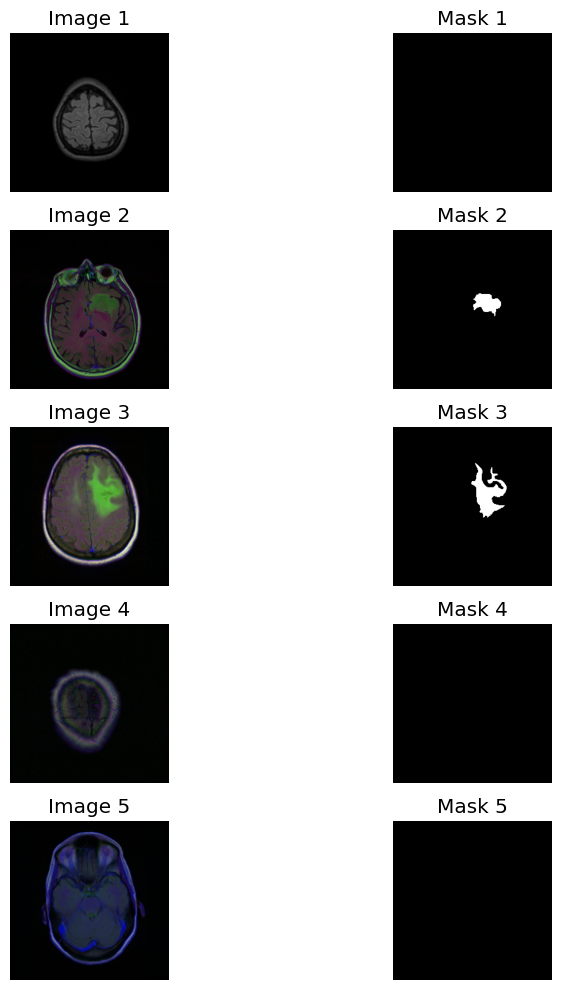

In [ ]:

num_images_to_show = 5  
fig, axes = plt.subplots(num_images_to_show, 2, figsize=(10, 10))

for i in range(num_images_to_show):
    image_path = train.iloc[i]['images']
    mask_path = train.iloc[i]['masks']  
    
    image = cv2.imread(image_path)  
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  

    image = cv2.resize(image, (256, 256))
    mask = cv2.resize(mask, (256, 256))

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    axes[i, 0].imshow(image_rgb)
    axes[i, 0].axis('off')
    axes[i, 0].set_title(f"Image {i + 1}")
    
    axes[i, 1].imshow(mask, cmap='gray')
    axes[i, 1].axis('off')
    axes[i, 1].set_title(f"Mask {i + 1}")

plt.tight_layout()
plt.show()


In [ ]:
val['images'] = val.apply(lambda row: os.path.join(DataPath, row['patient_id'], row['images']), axis=1)
val['masks'] = val.apply(lambda row: os.path.join(DataPath, row['patient_id'], row['masks']), axis=1)

val_generator = data_generator(
    data_frame=val,  
    batch_size=32,     
    aug_dict={},         
    target_size=(256, 256) 
)


In [ ]:
# Tester avec un sous-ensemble plus petit du DataFrame pour voir si le générateur fonctionne correctement
small_train_df = train.sample(n=10) 
small_train_generator = data_generator(
    data_frame=small_train_df,  
    batch_size=2,      
    aug_dict=data_augmentation, 
    target_size=(256, 256)
)

sample_small_batch = next(small_train_generator)

print("Small batch image shape:", sample_small_batch[0].shape)
print("Small batch mask shape:", sample_small_batch[1].shape)


Found 10 validated image filenames.
Found 10 validated image filenames.
Small batch image shape: (2, 256, 256, 3)
Small batch mask shape: (2, 256, 256, 1)


In [ ]:


def conv_block(x, filters):
    """Convolutional block with two Conv2D layers followed by Batch Normalization and ReLU activation."""
    x = Conv2D(filters, 3, padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization(axis=3)(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, 3, padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization(axis=3)(x)
    x = Activation('relu')(x)
    return x

def unet(pretrained_weights=None, input_size=(256, 256, 3)):
    inputs = Input(input_size)
    filters = [32 ,64, 128, 256, 512]
    conv_layers = []
    x = inputs

    for f in filters[:-1]:  
        x = conv_block(x, f)
        conv_layers.append(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)

    x = conv_block(x, filters[-1])

    for f, conv_layer in zip(reversed(filters[:-1]), reversed(conv_layers)):
        x = UpSampling2D(size=(2, 2))(x)
        x = Conv2D(f, 2, activation='relu', padding='same', kernel_initializer='he_normal')(x)
        x = concatenate([conv_layer, x], axis=3)
        x = conv_block(x, f)

    outputs = Conv2D(1, 1, activation='sigmoid')(x)
    model = Model(inputs=inputs, outputs=outputs)
    
    return model

In [19]:
model = unet()
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      9,248 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │     36,928 │ activation_2[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_4[0][0]  

 Total params: 7,771,873 (29.65 MB)

 Trainable params: 7,765,985 (29.62 MB)

 Non-trainable params: 5,888 (23.00 KB)

In [20]:
# Métriques de performance
smooth = 100

def iou_score(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true + y_pred)
    iou = (intersection + smooth) / (union - intersection + smooth)
    return iou

def dice_coefficient(y_true, y_pred):
    y_true_flat = K.flatten(y_true)
    y_pred_flat = K.flatten(y_pred)
    intersection = K.sum(y_true_flat * y_pred_flat)
    dice = (2 * intersection + smooth) / (K.sum(y_true_flat) + K.sum(y_pred_flat) + smooth)
    return dice

def dice_coefficient_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)


In [ ]:

lr_reduction = ReduceLROnPlateau(monitor='val_dice_coefficient', patience=8, verbose=1, factor=0.4, min_lr=0.0001)
early_stop = EarlyStopping(monitor='val_dice_coefficient', min_delta=0.00001, patience=6, mode='max', restore_best_weights=True)
model_checkpoint = ModelCheckpoint('unet_model.keras', monitor='val_dice_coefficient', verbose=1, save_best_only=True, mode='max')


In [ ]:
learning_rate = 1e-3

model.compile(
    optimizer=Adam(learning_rate=learning_rate, ), 
    loss=dice_coefficient_loss,
    metrics=[dice_coefficient, iou_score, Recall(), Precision()]
)
# Calcul des steps par époque (en prenant le nombre d'images / taille du batch)
steps_per_epoch = int(len(train) / 32)
validation_steps = int(len(val) / 32)
print(steps_per_epoch)
print(validation_steps)
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=50,
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=[lr_reduction, early_stop, model_checkpoint]
)



82
9
Found 2651 validated image filenames.
Found 2651 validated image filenames.
Epoch 1/80


I0000 00:00:1731671369.143456     324 service.cc:145] XLA service 0x7d82240419f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731671369.143530     324 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1731671400.208745     324 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 571ms/step - dice_coefficient: 0.0988 - iou_score: 0.0533 - loss: 0.9012 - precision: 0.0837 - recall: 0.8157Found 295 validated image filenames.
Found 295 validated image filenames.

Epoch 1: val_dice_coefficient improved from -inf to 0.02551, saving model to unet_model.keras
82/82 ━━━━━━━━━━━━━━━━━━━━ 94s 622ms/step - dice_coefficient: 0.0995 - iou_score: 0.0537 - loss: 0.9005 - precision: 0.0843 - recall: 0.8155 - val_dice_coefficient: 0.0255 - val_iou_score: 0.0130 - val_loss: 0.9745 - val_precision: 0.0129 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/80
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 564ms/step - dice_coefficient: 0.3567 - iou_score: 0.2237 - loss: 0.6418 - precision: 0.5205 - recall: 0.6902
Epoch 2: val_dice_coefficient improved from 0.02551 to 0.05621, saving model to unet_model.keras
82/82 ━━━━━━━━━━━━━━━━━━━━ 77s 622ms/step - dice_coefficient: 0.3576 - iou_score: 0.2244 - loss: 0.6410 - precision: 0.5209 - recall: 0.6902 - val_dice_coeffici

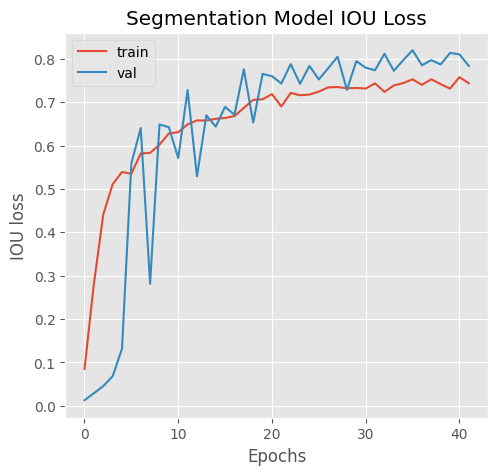

In [24]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['iou_score']);
plt.plot(history.history['val_iou_score']);
plt.title("Segmentation Model IOU Loss");
plt.ylabel("IOU loss");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

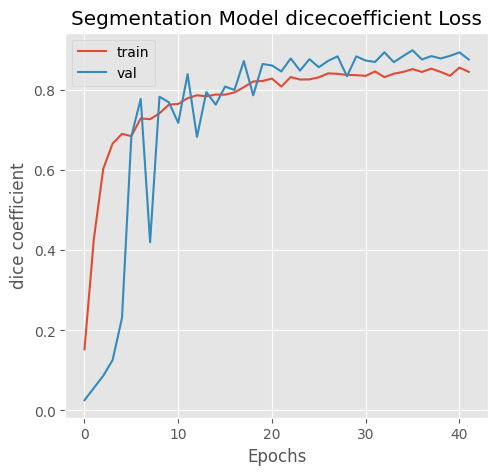

In [33]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['dice_coefficient']);
plt.plot(history.history['val_dice_coefficient']);
plt.title("Segmentation Model dicecoefficient Loss");
plt.ylabel("dice coefficient");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);


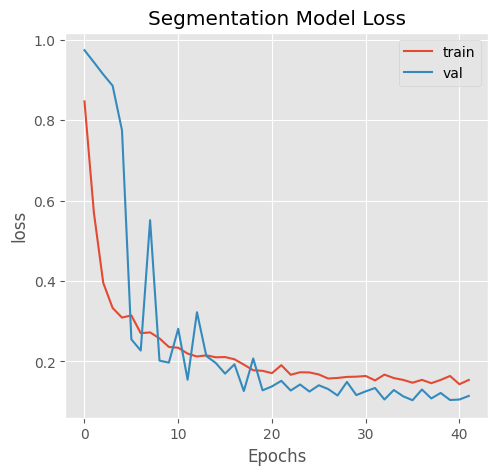

In [34]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss']);
plt.plot(history.history['val_loss']);
plt.title("Segmentation Model Loss");
plt.ylabel("loss");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

In [ ]:
DataPath = "/kaggle/working/lgg_mri_segmentation/kaggle_3m/"

test['images'] = test.apply(lambda row: DataPath + row['patient_id'] + "/" + row['images'], axis=1)
test['masks'] = test.apply(lambda row: DataPath + row['patient_id'] + "/" + row['masks'], axis=1)

print(test.head())

                 patient_id  \
1006  TCGA_HT_7680_19970202   
1217  TCGA_DU_6404_19850629   
3267  TCGA_DU_5852_19950709   
2033  TCGA_DU_6400_19830518   
3419  TCGA_FG_5962_20000626   

                                                 images  \
1006  /kaggle/working/lgg_mri_segmentation/kaggle_3m...   
1217  /kaggle/working/lgg_mri_segmentation/kaggle_3m...   
3267  /kaggle/working/lgg_mri_segmentation/kaggle_3m...   
2033  /kaggle/working/lgg_mri_segmentation/kaggle_3m...   
3419  /kaggle/working/lgg_mri_segmentation/kaggle_3m...   

                                                  masks  diagnosis  
1006  /kaggle/working/lgg_mri_segmentation/kaggle_3m...          0  
1217  /kaggle/working/lgg_mri_segmentation/kaggle_3m...          0  
3267  /kaggle/working/lgg_mri_segmentation/kaggle_3m...          1  
2033  /kaggle/working/lgg_mri_segmentation/kaggle_3m...          0  
3419  /kaggle/working/lgg_mri_segmentation/kaggle_3m...          1  


In [ ]:

def combined_generator(image_generator, mask_generator):
    while True:
        image_batch, mask_batch = next(image_generator), next(mask_generator)
        yield image_batch, mask_batch

image_datagen = ImageDataGenerator(rescale=1./255)
mask_datagen = ImageDataGenerator(rescale=1./255)

test_image_generator = image_datagen.flow_from_dataframe(
    dataframe=test,  
    x_col="images",   
    class_mode=None,  
    color_mode="rgb", 
    target_size=(256, 256),  
    batch_size=32,
    seed=42,
    validate_filenames=False  
)

test_mask_generator = mask_datagen.flow_from_dataframe(
    dataframe=test, 
    x_col="masks",   
    color_mode="grayscale", 
    target_size=(256, 256),  
    batch_size=32,
    seed=42,
    validate_filenames=False 
)

test_generator = combined_generator(test_image_generator, test_mask_generator)

steps_per_epoch_test = len(test) // 32 

# Évaluation du modèle sur l'ensemble de test
test_loss, test_dice_coef, test_iou, test_recall, test_precision = model.evaluate(
    test_generator, steps=steps_per_epoch_test, verbose=1
)

print(f"Test Loss: {test_loss}")
print(f"Test Dice Coefficient: {test_dice_coef}")
print(f"Test IoU: {test_iou}")
print(f"Test Recall: {test_recall}")
print(f"Test Precision: {test_precision}")

Found 983 non-validated image filenames.
Found 983 non-validated image filenames.
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - dice_coefficient: 0.8425 - iou_score: 0.7294 - loss: 0.1575 - precision: 0.8252 - recall: 0.8690
Test Loss: 0.1534142643213272
Test Dice Coefficient: 0.8465858697891235
Test IoU: 0.7358896732330322
Test Recall: 0.862720251083374
Test Precision: 0.8391136527061462


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


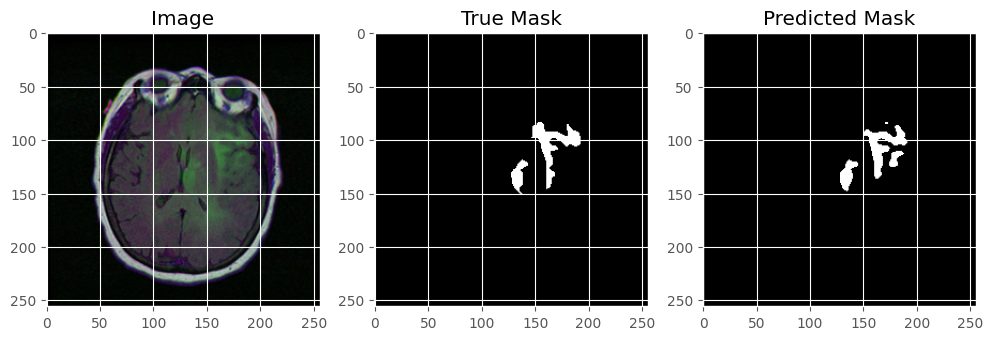

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


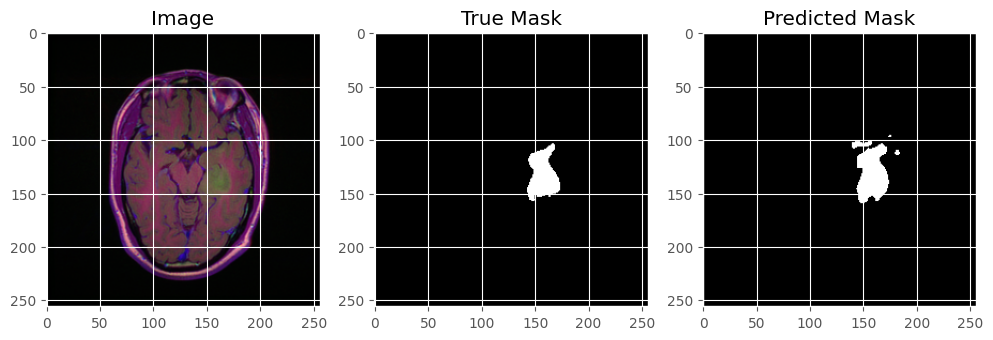

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


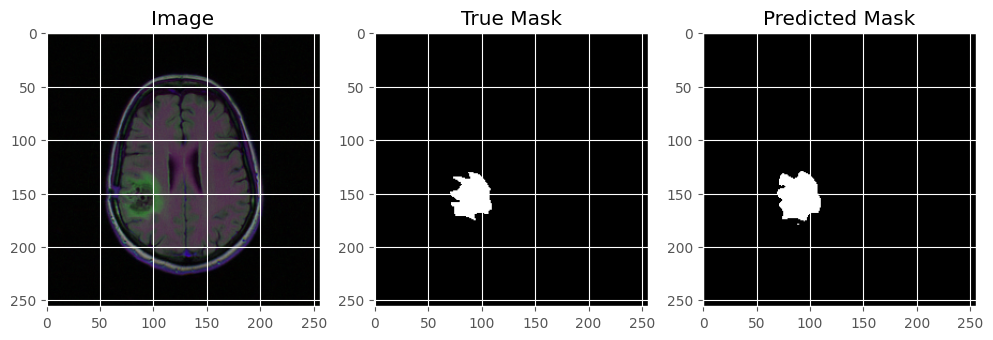

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


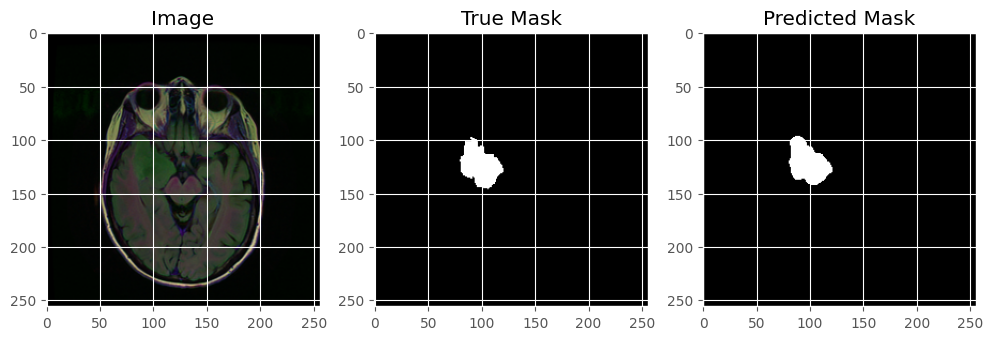

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


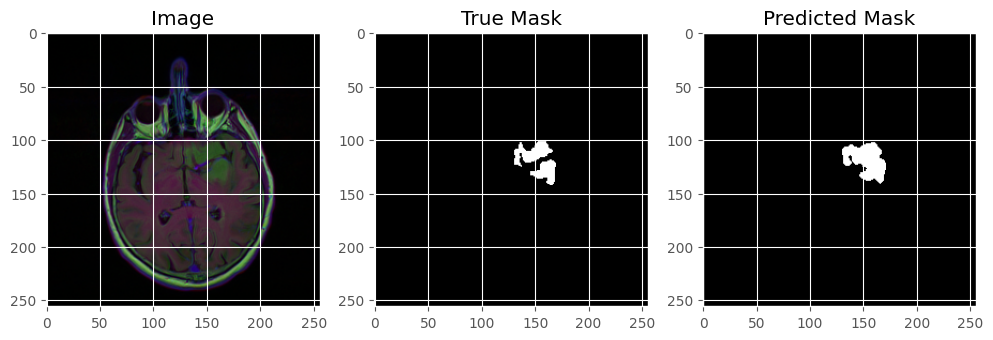

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


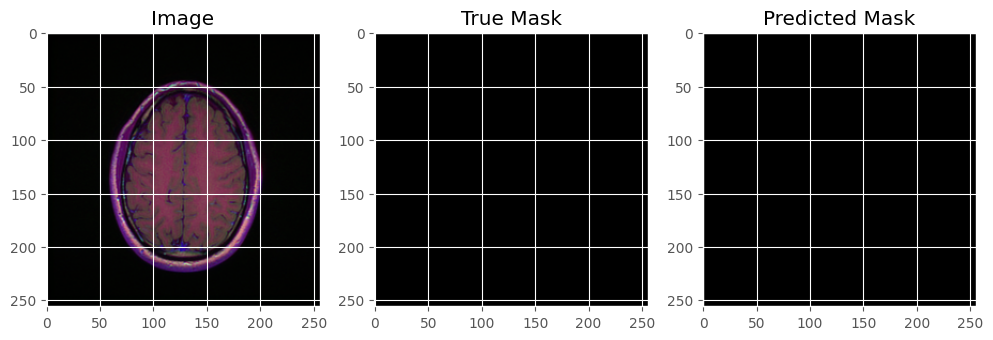

In [ ]:

for i in range(6):
    image, mask = next(test_generator)
    
    predicted_mask = model.predict(image)

    binary_predicted_mask = (predicted_mask > 0.5).astype(np.uint8)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.title("Image")
    plt.imshow(image[0])

    plt.subplot(1, 3, 2)
    plt.title("True Mask")
    plt.imshow(mask[0].squeeze(), cmap="gray")

    plt.subplot(1, 3, 3)
    plt.title("Predicted Mask")
    plt.imshow(binary_predicted_mask[0].squeeze(), cmap="gray")

    plt.show()